In [1]:
import dask.array as da
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from cellSAM.model import get_model
from skimage.segmentation import relabel_sequential

from cellSAM.model import get_local_model, segment_cellular_image
from cellSAM.utils import relabel_mask, get_median_size, enhance_low_contrast
from cellSAM.wsi import segment_wsi


def use_cellsize_gaging(
        inp,
        model,
        device,
        overlap=200,
        iou_depth=200,
        iou_threshold=0.5,
        bbox_threshold=0.4,
        medium_cell_threshold=0.002,
        tile_size=256,
):
    labels = segment_wsi(inp, overlap, iou_depth, iou_threshold, normalize=False, model=model,
                         device=device, bbox_threshold=bbox_threshold).compute()

    median_size, sizes, sizes_abs = get_median_size(labels)

    print(f"Median size: {median_size:.4f}")

    # only if cells are small we to WSI inference
    if median_size < medium_cell_threshold:
        doing_wsi = True
        # cells are medium or small -> do WSI
        inp = da.from_array(inp, chunks=tile_size)
        labels = segment_wsi(inp, overlap, iou_depth, iou_threshold, normalize=False, model=model,
                             device=device, bbox_threshold=bbox_threshold).compute()
    else:
        labels = segment_cellular_image(inp, model=model, normalize=False, device=device)[0]

    return labels


def prepare_labels(labels,
                border_size=5,
                cells_min_size=500,
                filter_below_min=True,
                ):
    # labels to individual masks
    # filter out masks smaller than min size if filter_below_min is true
    # this filter will only affect border cells and time taken scales with unique cells 
    # so can be disabled if not needed
    if filter_below_min:
        uniq_labs = np.unique(labels)
        masks = np.zeros((labels.shape[0], labels.shape[1]), dtype=np.int32)
        for idx in tqdm(range(len(uniq_labs))):
            mask = uniq_labs[idx]
            m_array = (labels == mask).astype(np.int32)
            if mask == 0:
                continue
            # is m_array at the edge?
            if m_array.sum() < cells_min_size and m_array[border_size:-border_size,
                                                    border_size:-border_size].sum() == 0:
                continue
            masks[(labels==mask)] = mask

        if len(masks) == 0:
            print("No cells found")
            return
        
        labels = masks

    # result = labels
    # result = relabel_mask(relabel_sequential(labels)[0]) 
    # relabel_mask already calls relabel_sequential, so above line seems redundant
    result = relabel_mask(labels)

    return result

def load_image(img, swap_channels=False):
    img = iio.imread(img)
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    if swap_channels:
        # switch last 2 channels bc nuclear and whoelcell are switched, #TODO: autmatically detect or have input arg like cellpose
        img = img[..., [0, 2, 1]]
    img = img.astype(np.float32)
    # normalize to 0-1 min max - channelwise
    for i in range(3):
        # To accomodate empty channels
        if (np.max(img[..., i]) - np.min(img[..., i])) != 0:
            img[..., i] = (img[..., i] - np.min(img[..., i])) / (np.max(img[..., i]) - np.min(img[..., i]))
        else:
            img[..., i] = img[..., i]

    return img


def cellsam_pipeline(
        img,  # str or np.array
        chunks=256,
        model_path=None,
        bbox_threshold=0.4,
        low_contrast_enhancement=True,
        swap_channels=False,
        use_wsi=True,
        gauge_cell_size=True,
        visualize=False,
        block_size=400,
        overlap=56,
        iou_depth=56,
        iou_threshold=0.5,
        filter_below_min=True, 
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if model_path is not None:
        modelpath = model_path
        model = get_local_model(modelpath)
        model.bbox_threshold = bbox_threshold
        model = model.to(device)
    else:
        model = None
        
        # To prevent creating model for each block
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Warning, using standard model. For better performance, use a model trained on your data.")
        model = get_model(None)
        model = model.to(device)
        model.eval()
        

    if isinstance(img, str):
        img = load_image(img, swap_channels=swap_channels)

    if low_contrast_enhancement:
        img = enhance_low_contrast(img)

    img = img[:1500, :1500, :]
    inp = da.from_array(img, chunks=chunks)

    if use_wsi:
        if gauge_cell_size:
            labels = use_cellsize_gaging(inp, model, device)
        else:
            labels = segment_wsi(inp, block_size, overlap, iou_depth, iou_threshold, normalize=False, model=model,
                                 device=device, bbox_threshold=bbox_threshold).compute()
    else:
        labels = segment_cellular_image(inp, model=model, normalize=False, device=device)[0]

    if visualize:
        labels = prepare_labels(labels, filter_below_min=filter_below_min)
        print(labels.max())
        plt.imshow(labels)
        plt.show()
        plt.imshow(img)
        plt.show()




/home/aiqbal/miniconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/aiqbal/miniconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/aiqbal/miniconda3/envs/cellsam/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pyto

Warning, using standard model. For better performance, use a model trained on your data.


/home/aiqbal/notebooks/cellSAM_devel/cellSAM/model.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<tifffile.TiffFile 'Ope

96


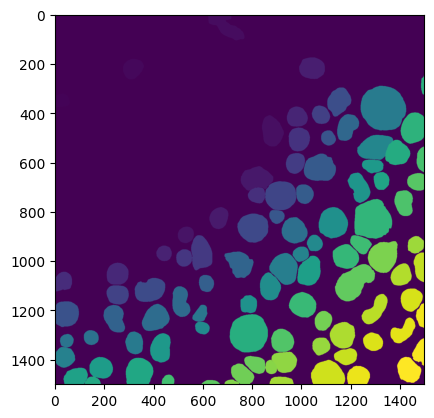

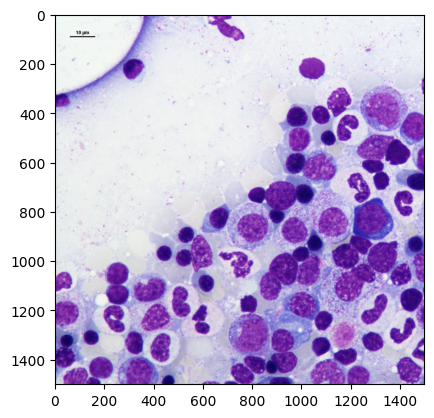

In [2]:
cellsam_pipeline(
    img='./debugdata/images/OpenTest_049.tif',
    # img='big_image.tiff',
    model_path=None,
    chunks=256,
    block_size=400,
    overlap=56,
    iou_depth=56,
    low_contrast_enhancement=False,
    use_wsi=False,
    gauge_cell_size=False,
    visualize=True,
)

Warning, using standard model. For better performance, use a model trained on your data.


/home/aiqbal/notebooks/cellSAM_devel/cellSAM/model.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<tifffile.TiffFile 'Ope

Total blocks: 9


1it [00:00,  1.10it/s]

unique in block, 11


2it [00:02,  1.04s/it]

unique in block, 15


3it [00:03,  1.18s/it]

unique in block, 19


4it [00:04,  1.12s/it]

unique in block, 13


5it [00:06,  1.34s/it]

unique in block, 26


6it [00:08,  1.60s/it]

unique in block, 33


7it [00:10,  1.80s/it]

unique in block, 33


8it [00:12,  1.96s/it]

unique in block, 35


9it [00:14,  1.66s/it]


unique in block, 32


100%|██████████| 93/93 [00:00<00:00, 539.81it/s]


87


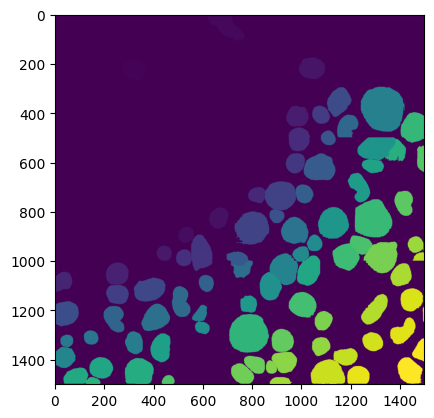

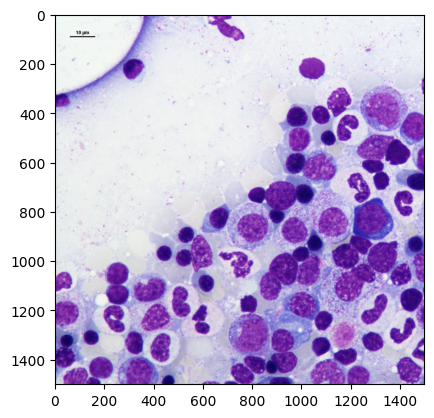

In [3]:
cellsam_pipeline(
    img='./debugdata/images/OpenTest_049.tif',
    # img='big_image.tiff',
    model_path=None,
    block_size=500,
    overlap=100,
    iou_depth=100,
    chunks=256,
    low_contrast_enhancement=False,
    use_wsi=True,
    gauge_cell_size=False,
    visualize=True,
)

Warning, using standard model. For better performance, use a model trained on your data.


/home/aiqbal/notebooks/cellSAM_devel/cellSAM/model.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<tifffile.TiffFile 'Ope

96


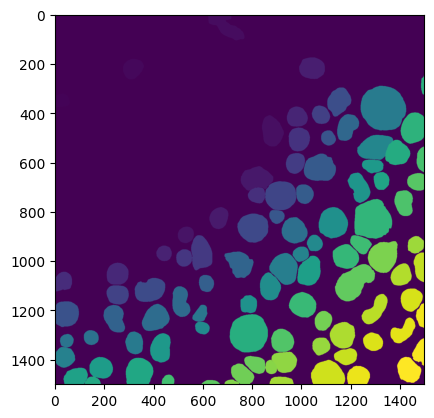

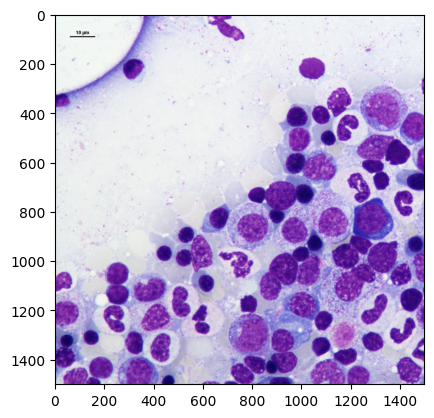

In [4]:
cellsam_pipeline(
    img='./debugdata/images/OpenTest_049.tif',
    # img = 'big_image.tiff',
    model_path=None,
    chunks=256,
    low_contrast_enhancement=False,
    use_wsi=False,
    gauge_cell_size=False,
    visualize=True,
)